<a href="https://colab.research.google.com/github/Edward-TL/amazon_scraper/blob/master/Amazon_Mx_Music_Rank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import

In [13]:
#For the system
import os

#Manage of time
from datetime import datetime, timedelta
from pytz import timezone
import time
import re

#Manage of files
import pandas as pd
import csv

#Graph tools
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import matplotlib.patches as mpatches

#interactive visualization
import plotly.express as px
import plotly.graph_objs as go

#Gauss-Jordan
import math

In [14]:
%cd 'drive/My Drive/Colab Notebooks/4SS/4SS_db/testing/Masters/mx/parquet'
!ls

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/4SS/4SS_db/testing/Masters/mx/parquet'
/content/drive/My Drive/Colab Notebooks/4SS/4SS_db/testing/Masters/mx/parquet
mx-master_db_amazon-devices.parquet  mx-master_db_kitchen.parquet
mx-master_db_automotive.parquet      mx-master_db_musical-instruments.parquet
mx-master_db_baby.parquet	     mx-master_db_music.parquet
mx-master_db_books.parquet	     mx-master_db_officeproduct.parquet
mx-master_db_digital-text.parquet    mx-master_db_pet-supplies.parquet
mx-master_db_dvd.parquet	     mx-master_db_shoes.parquet
mx-master_db_electronics.parquet     mx-master_db_software.parquet
mx-master_db_grocery.parquet	     mx-master_db_sports.parquet
mx-master_db_handmade.parquet	     mx-master_db_tools.parquet
mx-master_db_hpc.parquet	     mx-master_db_toys.parquet
mx-master_db_industrial.parquet      mx-master_db_videogames.parquet


In [42]:
df.columns

Index(['time', 'Rank', 'Product Names', 'Product ID', 'Image ID', 'Stars',
       'Reviews', 'Authors/Company', 'Edition/Console', 'Price_std_or_min',
       'Max_prices'],
      dtype='object')

# Tools

## Count if

In [16]:
def count_if(array, value):
    count = 0
    for element in array:
        if element == value:
            count += 1
    return count

## array count

In [34]:
def array_count(elements_to_count, original_array):
    count_array = [None] * len(elements_to_count)
    c = 0

    for value in range(len(elements_to_count)):
        count_array[c] = original_array.count(elements_to_count[value])
        c += 1
        
    return count_array

## rank set list

In [40]:
def rank_set_list(df, rank, info, set_list=True, array=True):
    ranking = df[df['Rank'] == rank]
    raw_info_in_rank = ranking[info].to_list()

    if set_list == True:
        set_info = list(set(raw_info_in_rank))
        none_cases = count_if(set_info, None)
        if none_cases > 0:
            set_info.remove(None)

        if array == True:
            return set_info, raw_info_in_rank

        else: return set_info
    
    else: return raw_info_in_rank

    

# Plots

No handles with labels found to put in legend.


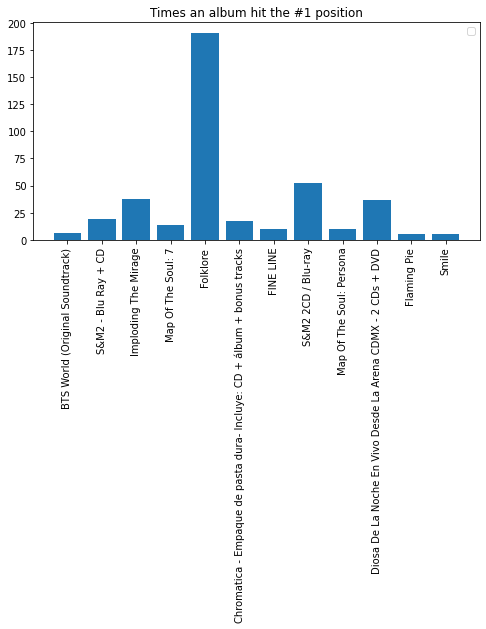

No handles with labels found to put in legend.


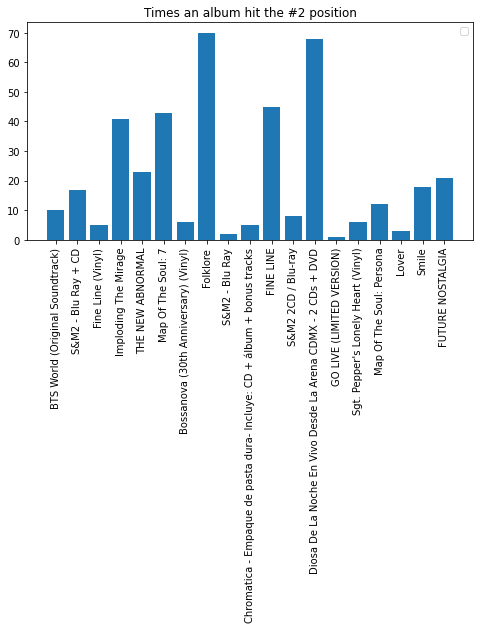

No handles with labels found to put in legend.


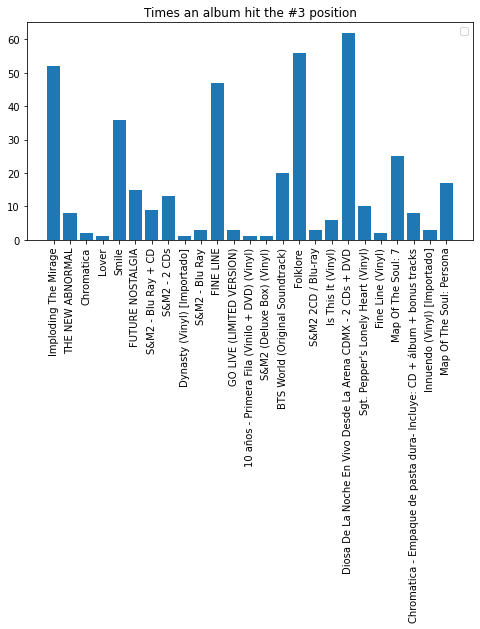

No handles with labels found to put in legend.


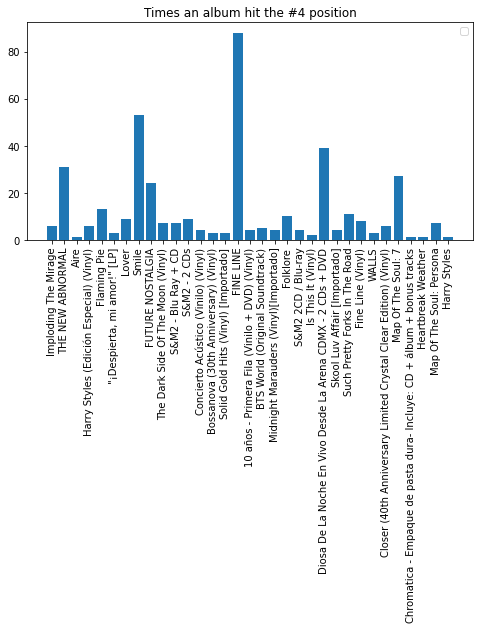

No handles with labels found to put in legend.


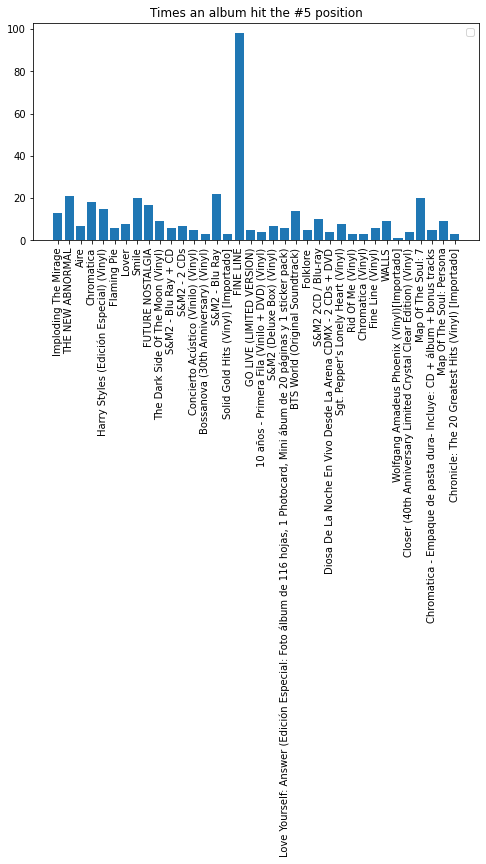

In [43]:
for rank in range(1,6):
    
    #Extract Info
    albums = "Product Names"
    set_albums, raw_albums_in_rank = rank_set_list(df, rank, info=albums)
    album_count = array_count(elements_to_count=set_albums, original_array=raw_albums_in_rank)
    
    reviews = "Reviews"
    set_reviews = rank_set_list(df, rank, info=reviews)

    stars = "Stars"
    set_stars = rank_set_list(df, rank, info=stars)

    #Plot
    plt.figure(figsize=(8,4))
    plt.bar(x=set_albums, height=album_count)
    plt.xticks(rotation='vertical')

    header = f'Times an album hit the #{rank} position' 
    plt.title(label=header)
    plt.legend(loc='best', bbox_to_anchor=(1,1), ncol=2)

    plt.show()